# Laporan Project Machine learning - Candra Burhanudin
# Dataset : [Anime Recommendations Database](https://www.kaggle.com/datasets/CooperUnion/anime-recommendations-database?select=rating.csv)


## Data Understanding

> install paket kaggle (dataset berasal dari platform KAGGLE) & Import Library yang dibutuhkan


In [1]:
!pip install kaggle

> membuat direktori .kaggle di dalam direktori beranda user /root/.kaggle lalu menyalin file kaggle.json ke direktori .kaggle

In [2]:
! mkdir ~/.kaggle


In [3]:
! cp kaggle.json ~/.kaggle/


> atur izin akses file kaggle.json menjadi 600 (hanya pemilik file yg memiliki izin read & write. pengguna lain tidak diizinkan) dan mulai proses unduh dataset menggunakan kaggle datasets download

In [4]:
! chmod 600 ~/.kaggle/kaggle.json


In [5]:
!kaggle datasets download -d CooperUnion/anime-recommendations-database

 56% 14.0M/25.0M [00:00<00:00, 65.1MB/s]
100% 25.0M/25.0M [00:00<00:00, 84.6MB/s]


In [120]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from zipfile import ZipFile
from tensorflow import keras
from tensorflow.keras import layers
from pathlib import Path
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

> ekstrak dataset menggunakan libbrary zipfile di direktori /content/ / lalu untuk membaca dataset format csv dilakukan dengan library pandas pd.read_csv(alamat file)

In [7]:
zip_file_path = '/content/anime-recommendations-database.zip'
with ZipFile(zip_file_path, 'r') as zip_ref :
  zip_ref.extractall('/content/')

In [8]:
df_anime = pd.read_csv('/content/anime.csv')
df_rating = pd.read_csv('/content/rating.csv')
print('jumlah data anime : ', len(df_anime.anime_id.unique()))
print('jumlah data penilaian yang diberikan pengguna : ',len(df_rating.rating))
print('jumlah user yang memberikan rating : ',len(df_rating.user_id.unique()))


jumlah data anime :  12294
jumlah data penilaian yang diberikan pengguna :  7813737
jumlah user yang memberikan rating :  73515


## Univariate Exploratory Data Analysis
Anime.csv
* anime_id - myanimelist.net's unique id identifying an anime.
name - full name of anime.
* genre - comma separated list of genres for this anime.
* type - movie, TV, OVA, etc.
episodes - how many episodes in this show. (1 if movie).
* rating - average rating out of 10 for this anime.
* members - number of community members that are in this anime's
"group".

Rating.csv

* user_id - non identifiable randomly generated user id.
* anime_id - the anime that this user has rated.
* rating - rating out of 10 this user has assigned (-1 if the user watched it but didn't assign a rating).
> pada proyek ini, kita akan mengeksplorasi beberapa variabel saja, antara lain: df_anime, df_rating.

### Data Anime

> memotong data hingga 10000 record

In [9]:
df_anime = df_anime[:10000]

In [10]:
df_anime.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   anime_id  10000 non-null  int64  
 1   name      10000 non-null  object 
 2   genre     9960 non-null   object 
 3   type      10000 non-null  object 
 4   episodes  10000 non-null  object 
 5   rating    9998 non-null   float64
 6   members   10000 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 547.0+ KB


In [11]:
print('banyak data Anime : ',len(df_anime.anime_id.unique()))
print('jumlah genre Anime : ',len(df_anime.genre.unique()))

banyak data Anime :  10000
jumlah genre Anime :  3000


> Filter Data dengan membuang data yang tidak pantas digunakan

In [12]:
df_anime_filtered = df_anime[~df_anime['genre'].apply(lambda x: isinstance(x, float) or 'Hentai' in x)]

In [13]:
print('banyak data Anime setelah filtrasi : ',len(df_anime_filtered.anime_id.unique()))
print('jumlah genre Anime setelah filtrasi: ',len(df_anime_filtered.genre.unique()))
print('genre Anime setelah filtrasi: ',df_anime_filtered.genre.unique())

banyak data Anime setelah filtrasi :  9960
jumlah genre Anime setelah filtrasi:  2999
genre Anime setelah filtrasi:  ['Drama, Romance, School, Supernatural'
 'Action, Adventure, Drama, Fantasy, Magic, Military, Shounen'
 'Action, Comedy, Historical, Parody, Samurai, Sci-Fi, Shounen' ...
 'Action, Drama, Military, Seinen' 'Comedy, Kids, School'
 'Adventure, Fantasy, Kids, Magic, Martial Arts']


In [14]:
df_anime_filtered

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266
...,...,...,...,...,...,...,...
9995,22623,Pochacco no Ninjin Hata wa Oosawagi,"Fantasy, Kids",OVA,1,6.35,76
9996,22617,Pochacco no Wakuwaku Birthday,"Fantasy, Kids",OVA,1,6.00,74
9997,17613,Poka Poka Mori no Rascal,Kids,TV,52,5.22,93
9998,32621,Pokopon no Yukai na Saiyuuki,"Adventure, Fantasy, Kids, Magic, Martial Arts",Movie,1,5.57,35


### Data Anime User Rating

memotong data hingga 10000 record

In [151]:
df_rating = df_rating[:10000]

In [16]:
df_rating.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   user_id   10000 non-null  int64
 1   anime_id  10000 non-null  int64
 2   rating    10000 non-null  int64
dtypes: int64(3)
memory usage: 234.5 KB


In [152]:
df_rating.sample(5)

,user_id,anime_id,rating
9356,120,14833,9
8163,99,430,5
6391,67,10790,9
1058,7,23755,8
2238,18,22319,10


In [153]:
print('banyak data User : ',len(df_rating.user_id.unique()))
print('banyak data Anime : ',len(df_rating.anime_id.unique()))

banyak data User :  123
banyak data Anime :  2402


In [154]:
# Salin slice DataFrame ke DataFrame baru
df_rating_copy = df_rating.copy()

> menambahkan huruf pada `user_id` agar id lebih bersifat unik

In [155]:
df_rating_copy.loc[:,'user_id'] = 'U' + df_rating_copy['user_id'].astype(str)

> karena jumlah banyak anime pada `df_rating` dan `df_anime_filtered` berbeda karena sudah melalui tahap filtered maka pada `df_rating` dilakukan penyesuaian agar jumlah anime sama sesuai dengan anime_id pada `df_anime_filtered`

> mengganti nilai rating yang invalid (nilai -1 diganti menjadi 0)

In [156]:
df_rating_copy['rating'] = df_rating_copy['rating'].replace(-1, 0)

In [157]:
df_rating_filtered = df_rating_copy[df_rating_copy['anime_id'].isin(df_anime_filtered['anime_id'])]
df_rating_filtered.sample(5)

,user_id,anime_id,rating
176,U3,1764,6
8424,U104,169,6
4064,U43,7148,8
1484,U14,969,7
7631,U90,11061,10


> Menselaraskan  anime_id pada `df_anime_filtered` dengan `df_rating_filtered` agar jumlahnya sama

In [158]:
df_anime_filtered = df_anime_filtered[df_anime_filtered['anime_id'].isin(df_rating_filtered['anime_id'])]

In [159]:
df_anime_filtered

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266
...,...,...,...,...,...,...,...
7926,32467,Under the Dog: Anthea-chan,"Action, Comedy, Parody",ONA,1,4.62,2390
8016,22377,Wonder Momo,"Action, Game, Martial Arts, School",ONA,5,3.90,3218
8024,19315,Pupa,"Fantasy, Horror, Psychological",TV,12,3.82,83652
8056,413,Hametsu no Mars,"Horror, Sci-Fi",OVA,1,2.37,27557


In [160]:
print('banyak data Anime setelah filtrasi di dataframe df_anime_filtered: ',len(df_anime_filtered.anime_id.unique()))

banyak data Anime setelah filtrasi di dataframe df_anime_filtered:  2355


In [161]:
print('banyak data pengguna setelah filtrasi : ',len(df_rating_filtered.user_id.unique()))
print('banyak data Anime setelah filtrasi di dataframe df_rating_filtered : ',len(df_rating_filtered.anime_id.unique()))
print('rating yang diberikan oleh pengguna :' ,(df_rating_filtered.rating.unique()))

banyak data pengguna setelah filtrasi :  123
banyak data Anime setelah filtrasi di dataframe df_rating_filtered :  2355
rating yang diberikan oleh pengguna : [ 0 10  8  6  9  7  3  5  4  1  2]


In [162]:
df_rating_filtered.sample(5)

,user_id,anime_id,rating
6859,U77,10719,8
9539,U122,13759,10
5976,U54,30437,0
6960,U77,30015,9
3931,U41,14289,10


### Distribusi Data Anime Dan Data Rating User

In [163]:
df_anime_filtered.describe()

,anime_id,rating,members
count,2355.000000,2355.000000,2.355000e+03
mean,11379.809766,7.373567,7.852022e+04
std,10080.878485,0.696964,1.030869e+05
min,1.000000,2.000000,3.930000e+02
25%,1841.000000,6.940000,1.863750e+04
50%,9135.000000,7.410000,4.361500e+04
75%,19178.000000,7.820000,9.443250e+04
max,34240.000000,9.370000,1.013917e+06


In [164]:
df_rating_filtered.describe()

,anime_id,rating
count,9935.000000,9935.000000
mean,10583.164670,6.006341
std,8927.085229,3.596083
min,1.000000,0.000000
25%,2167.000000,3.000000
50%,9367.000000,7.000000
75%,16526.000000,9.000000
max,34240.000000,10.000000


## Data Preparation

> Cek Missing Value

In [165]:
df_anime_filtered.isnull().sum()

anime_id    0
name        0
genre       0
type        0
episodes    0
rating      0
members     0
dtype: int64

In [166]:
df_rating_filtered.isnull().sum()

user_id     0
anime_id    0
rating      0
dtype: int64

> Menggabungkan data anime

In [167]:
anime_all = np.concatenate((
    df_anime_filtered.anime_id.unique(),
    df_rating_filtered.anime_id.unique()
))

anime_all = np.sort(np.unique(anime_all))
print('jumlah seluruh data anime berdasarkan anime_id: ', len(anime_all))

jumlah seluruh data anime berdasarkan anime_id:  2355


In [168]:
all_anime = pd.merge( df_rating_filtered, df_anime_filtered , on='anime_id')
all_anime.sample(10)

,user_id,anime_id,rating_x,name,genre,type,episodes,rating_y,members
5430,U120,2167,10,Clannad,"Comedy, Drama, Romance, School, Slice of Life,...",TV,23,8.30,566690
2023,U73,1535,8,Death Note,"Mystery, Police, Psychological, Supernatural, ...",TV,37,8.71,1013917
7553,U93,19685,6,Kanojo ga Flag wo Oraretara,"Comedy, Harem, Romance, School",TV,13,6.58,74634
6167,U11,431,8,Howl no Ugoku Shiro,"Adventure, Drama, Fantasy, Romance",Movie,1,8.74,333186
8479,U36,3470,10,Special A,"Comedy, Romance, School, Shoujo",TV,24,7.78,173603
87,U96,241,9,Girls Bravo: First Season,"Comedy, Ecchi, Fantasy, Harem, Romance, School",TV,11,6.69,84395
3481,U7,1257,7,Saint Seiya: Meiou Hades Juuni Kyuu-hen,"Adventure, Sci-Fi, Shounen",OVA,13,8.26,23701
379,U122,5958,10,Sora no Otoshimono,"Comedy, Ecchi, Harem, Romance, Sci-Fi, Shounen...",TV,13,7.68,227681
9505,U120,31223,0,Phantasy Star Online 2 The Animation,"Action, Game, School, Sci-Fi",TV,12,6.50,32470
2334,U43,14075,8,Zetsuen no Tempest,"Action, Drama, Fantasy, Magic, Mystery, Psycho...",TV,24,8.17,259900


> Mengurutkan data secara ascending menurut fitur anime_id

In [169]:
preparation = all_anime
preparation.sort_values('anime_id')

,user_id,anime_id,rating_x,name,genre,type,episodes,rating_y,members
6548,U103,1,8,Cowboy Bebop,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",TV,26,8.82,486824
6541,U51,1,10,Cowboy Bebop,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",TV,26,8.82,486824
6542,U54,1,0,Cowboy Bebop,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",TV,26,8.82,486824
6543,U55,1,8,Cowboy Bebop,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",TV,26,8.82,486824
6544,U68,1,8,Cowboy Bebop,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",TV,26,8.82,486824
...,...,...,...,...,...,...,...,...,...
7842,U17,33934,0,Trigger-chan,Action,ONA,1,6.51,5051
7845,U77,34240,6,Shelter,"Music, Sci-Fi",Music,1,8.38,71136
7844,U46,34240,10,Shelter,"Music, Sci-Fi",Music,1,8.38,71136
7843,U17,34240,8,Shelter,"Music, Sci-Fi",Music,1,8.38,71136


> data yang digunakan hanya menggunakan data unik untuk dimasukkan ke dalam proses pemodelan, oleh karena itu perlu menghapus data yang duplikat

In [170]:
preparation = preparation.drop_duplicates('anime_id')
preparation.sort_values('anime_id')

,user_id,anime_id,rating_x,name,genre,type,episodes,rating_y,members
6532,U13,1,0,Cowboy Bebop,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",TV,26,8.82,486824
6549,U13,5,0,Cowboy Bebop: Tengoku no Tobira,"Action, Drama, Mystery, Sci-Fi, Space",Movie,1,8.40,137636
2669,U4,6,0,Trigun,"Action, Comedy, Sci-Fi",TV,26,8.32,283069
9105,U54,7,0,Witch Hunter Robin,"Action, Drama, Magic, Mystery, Police, Superna...",TV,26,7.36,64905
3075,U5,15,6,Eyeshield 21,"Action, Comedy, Shounen, Sports",TV,145,8.08,83648
...,...,...,...,...,...,...,...,...,...
7839,U17,33522,0,Chiba Pedal: Yowamushi Pedal to Manabu Jitensh...,"Shounen, Sports",ONA,6,6.20,1867
7840,U17,33524,0,Sakamoto desu ga? Special,"Comedy, School, Seinen",Special,1,6.80,23745
7841,U17,33569,0,Re:Petit kara Hajimeru Isekai Seikatsu,"Adventure, Comedy, Fantasy",Special,14,6.95,14310
7842,U17,33934,0,Trigger-chan,Action,ONA,1,6.51,5051


> Konversi Data series menjadi list

In [171]:
anime_id = preparation['anime_id'].tolist()
anime_name = preparation['name'].tolist()
anime_genre = preparation['genre'].tolist()
print(len(anime_id))
print(len(anime_name))
print(len(anime_genre))

2355
2355
2355


> membuat dictionary untuk menentukan pasangan key-value pada data anime_id, anime_name, anime_genre

In [172]:
anime_new = pd.DataFrame({
    'id': anime_id,
    'anime_name': anime_name,
    'anime_genre': anime_genre
})
anime_new

,id,anime_name,anime_genre
0,20,Naruto,"Action, Comedy, Martial Arts, Shounen, Super P..."
1,24,School Rumble,"Comedy, Romance, School, Shounen"
2,79,Shuffle!,"Comedy, Drama, Ecchi, Fantasy, Harem, Magic, R..."
3,226,Elfen Lied,"Action, Drama, Horror, Psychological, Romance,..."
4,241,Girls Bravo: First Season,"Comedy, Ecchi, Fantasy, Harem, Romance, School"
...,...,...,...
2350,31973,Mobile Suit Gundam Thunderbolt,"Action, Drama, Mecha, Military, Sci-Fi, Space"
2351,32011,Hakuouki: Otogisoushi,"Fantasy, Historical, Josei, Samurai"
2352,32175,Shounen Maid,"Comedy, Shoujo, Slice of Life"
2353,32245,Kuromukuro,"Action, Mecha, Sci-Fi"


### Encoding Fitur User_id

> mengubah user_id menjadi list tanpa nilai yang sama

In [173]:
user_ids = df_rating_filtered['user_id'].unique().tolist()
print('list user_id ', user_ids)

list user_id  ['U1', 'U2', 'U3', 'U4', 'U5', 'U6', 'U7', 'U8', 'U9', 'U10', 'U11', 'U12', 'U13', 'U14', 'U15', 'U16', 'U17', 'U18', 'U19', 'U20', 'U21', 'U22', 'U23', 'U24', 'U25', 'U26', 'U27', 'U28', 'U29', 'U30', 'U31', 'U32', 'U33', 'U34', 'U35', 'U36', 'U37', 'U38', 'U39', 'U40', 'U41', 'U42', 'U43', 'U44', 'U45', 'U46', 'U47', 'U48', 'U49', 'U50', 'U51', 'U52', 'U53', 'U54', 'U55', 'U56', 'U57', 'U58', 'U59', 'U60', 'U61', 'U62', 'U63', 'U64', 'U65', 'U66', 'U67', 'U68', 'U69', 'U70', 'U71', 'U72', 'U73', 'U74', 'U75', 'U76', 'U77', 'U78', 'U79', 'U80', 'U81', 'U82', 'U83', 'U84', 'U85', 'U86', 'U87', 'U88', 'U89', 'U90', 'U91', 'U92', 'U93', 'U94', 'U95', 'U96', 'U97', 'U98', 'U99', 'U100', 'U101', 'U102', 'U103', 'U104', 'U105', 'U106', 'U107', 'U108', 'U109', 'U110', 'U111', 'U112', 'U113', 'U114', 'U115', 'U116', 'U117', 'U118', 'U119', 'U120', 'U121', 'U122', 'U123']


 > melakukan encoding user_id & encoding angka ke user_id

In [174]:

user_to_user_encoded = {x : i for i,x in enumerate(user_ids)}
print('encode user_id : ',user_to_user_encoded)

user_encoded_to_user = {i : x for i,x in enumerate(user_ids)}
print('encoded angka ke user_id',user_encoded_to_user)

encode user_id :  {'U1': 0, 'U2': 1, 'U3': 2, 'U4': 3, 'U5': 4, 'U6': 5, 'U7': 6, 'U8': 7, 'U9': 8, 'U10': 9, 'U11': 10, 'U12': 11, 'U13': 12, 'U14': 13, 'U15': 14, 'U16': 15, 'U17': 16, 'U18': 17, 'U19': 18, 'U20': 19, 'U21': 20, 'U22': 21, 'U23': 22, 'U24': 23, 'U25': 24, 'U26': 25, 'U27': 26, 'U28': 27, 'U29': 28, 'U30': 29, 'U31': 30, 'U32': 31, 'U33': 32, 'U34': 33, 'U35': 34, 'U36': 35, 'U37': 36, 'U38': 37, 'U39': 38, 'U40': 39, 'U41': 40, 'U42': 41, 'U43': 42, 'U44': 43, 'U45': 44, 'U46': 45, 'U47': 46, 'U48': 47, 'U49': 48, 'U50': 49, 'U51': 50, 'U52': 51, 'U53': 52, 'U54': 53, 'U55': 54, 'U56': 55, 'U57': 56, 'U58': 57, 'U59': 58, 'U60': 59, 'U61': 60, 'U62': 61, 'U63': 62, 'U64': 63, 'U65': 64, 'U66': 65, 'U67': 66, 'U68': 67, 'U69': 68, 'U70': 69, 'U71': 70, 'U72': 71, 'U73': 72, 'U74': 73, 'U75': 74, 'U76': 75, 'U77': 76, 'U78': 77, 'U79': 78, 'U80': 79, 'U81': 80, 'U82': 81, 'U83': 82, 'U84': 83, 'U85': 84, 'U86': 85, 'U87': 86, 'U88': 87, 'U89': 88, 'U90': 89, 'U91': 90,

### Encoding Fitur anime_id

> petakan user_id dan dan anime_id ke dataframe yang berkaitan


In [175]:
anime_ids = df_rating_filtered['anime_id'].unique().tolist()
print(anime_ids)

[20, 24, 79, 226, 241, 355, 356, 442, 487, 846, 936, 1546, 1692, 1836, 2001, 2025, 2144, 2787, 2993, 3455, 4063, 4214, 4224, 4581, 4744, 4898, 4999, 5034, 5277, 5667, 5781, 5958, 6163, 6205, 6324, 6500, 6547, 6682, 6707, 6747, 6773, 6793, 7088, 7148, 7593, 7739, 7858, 8074, 8407, 8424, 8525, 8630, 8841, 9041, 9062, 9136, 9181, 9330, 9367, 9515, 9581, 9675, 9750, 9790, 9919, 10067, 10073, 10076, 10079, 10080, 10209, 10578, 10604, 10719, 10790, 10793, 10794, 10805, 10897, 11161, 11266, 11617, 11737, 11757, 11759, 11771, 12293, 12549, 12729, 13357, 13367, 13411, 13561, 13663, 13759, 14749, 14813, 14833, 14967, 15117, 15437, 15451, 15583, 15609, 16011, 16498, 16706, 17265, 17729, 18247, 18277, 18753, 18897, 19163, 19221, 19285, 19429, 19815, 20045, 20785, 20787, 21033, 21881, 22147, 22199, 22319, 22535, 22547, 22663, 22877, 23233, 23321, 23847, 24133, 24455, 24873, 25099, 25157, 25159, 25283, 25397, 26243, 27775, 27899, 28121, 28677, 29093, 29095, 30015, 30296, 30544, 31338, 31845, 12189, 

> melakukan proses encoding anime_id dan proses encoding angka ke anime_id

In [176]:
anime_to_anime_encoded = {x: i for i, x in enumerate(anime_ids)}
print('encode anime_id : ',anime_to_anime_encoded)
anime_encoded_to_anime = {i: x for i, x in enumerate(anime_ids)}
print('encode angka ke anime_id : ',anime_encoded_to_anime)

encode anime_id :  {20: 0, 24: 1, 79: 2, 226: 3, 241: 4, 355: 5, 356: 6, 442: 7, 487: 8, 846: 9, 936: 10, 1546: 11, 1692: 12, 1836: 13, 2001: 14, 2025: 15, 2144: 16, 2787: 17, 2993: 18, 3455: 19, 4063: 20, 4214: 21, 4224: 22, 4581: 23, 4744: 24, 4898: 25, 4999: 26, 5034: 27, 5277: 28, 5667: 29, 5781: 30, 5958: 31, 6163: 32, 6205: 33, 6324: 34, 6500: 35, 6547: 36, 6682: 37, 6707: 38, 6747: 39, 6773: 40, 6793: 41, 7088: 42, 7148: 43, 7593: 44, 7739: 45, 7858: 46, 8074: 47, 8407: 48, 8424: 49, 8525: 50, 8630: 51, 8841: 52, 9041: 53, 9062: 54, 9136: 55, 9181: 56, 9330: 57, 9367: 58, 9515: 59, 9581: 60, 9675: 61, 9750: 62, 9790: 63, 9919: 64, 10067: 65, 10073: 66, 10076: 67, 10079: 68, 10080: 69, 10209: 70, 10578: 71, 10604: 72, 10719: 73, 10790: 74, 10793: 75, 10794: 76, 10805: 77, 10897: 78, 11161: 79, 11266: 80, 11617: 81, 11737: 82, 11757: 83, 11759: 84, 11771: 85, 12293: 86, 12549: 87, 12729: 88, 13357: 89, 13367: 90, 13411: 91, 13561: 92, 13663: 93, 13759: 94, 14749: 95, 14813: 96, 14

### Membuat fitur user & anime

> petakan user_id dan anime_id ke dataframe

In [177]:
df_rating_filtered_copy = df_rating_filtered.copy()

In [178]:
df_rating_filtered_copy['user']= df_rating_filtered_copy['user_id'].map(user_to_user_encoded)
df_rating_filtered_copy['anime']= df_rating_filtered_copy['anime_id'].map(anime_to_anime_encoded)

In [179]:
df_rating_filtered_copy['user']

0         0
1         0
2         0
3         0
4         0
       ... 
9995    122
9996    122
9997    122
9998    122
9999    122
Name: user, Length: 9935, dtype: int64

In [180]:
df_rating_filtered_copy.sample(5)

,user_id,anime_id,rating,user,anime
1659,U17,1109,0,16,1020
3698,U39,11843,0,38,466
7848,U94,22535,9,93,126
5528,U54,5958,0,53,31
7707,U93,9201,6,92,1348


> cek missing value pada dataframe rating

In [181]:
df_rating_filtered_copy.isnull().sum()

user_id     0
anime_id    0
rating      0
user        0
anime       0
dtype: int64

In [182]:
df_rating_filtered_copy.sample(10)

,user_id,anime_id,rating,user,anime
1579,U14,17247,7,13,517
1518,U14,7817,5,13,418
8036,U98,3389,6,97,1559
6647,U73,12487,9,72,1943
8130,U98,19669,0,97,1152
6362,U66,9989,0,65,191
1462,U13,20709,0,12,955
3158,U34,4835,0,33,1433
4325,U44,10863,8,43,452
4773,U48,2593,9,47,1025


### Standarisasi Data

> cek beberapa hal dalam data seperti jumlah user, jumlah anime, kemudian mengubah nilai rating menjadi float

In [183]:
num_users = len(user_to_user_encoded)
num_anime = len(anime_encoded_to_anime)
df_rating_filtered_copy['rating'] = df_rating_filtered_copy['rating'].values.astype(np.float32)
min_rating = min(df_rating_filtered['rating'])
max_rating = max(df_rating_filtered['rating'])
print('Number of User: {}, Number of Anime: {}, Min Rating: {}, Max Rating: {}'.format(
    num_users, num_anime, min_rating, max_rating
))

Number of User: 123, Number of Anime: 2355, Min Rating: 0, Max Rating: 10


## Sistem Rekomendasi Dengan Teknik Content-Based

### TF-IDF Vectorizer

In [184]:
data = anime_new
data.sample(5)

,id,anime_name,anime_genre
2106,9735,Gintama: Shinyaku Benizakura-hen,"Action, Comedy, Historical, Parody, Samurai, S..."
369,2961,Digimon Adventure Movie,"Action, Fantasy, Kids, Sci-Fi"
825,452,InuYasha: Toki wo Koeru Omoi,"Adventure, Comedy, Demons, Drama, Fantasy, His..."
2101,1690,Bokurano,"Drama, Mecha, Psychological, Sci-Fi"
1200,23831,Mahou Shoujo Madoka★Magica Movie 3: Hangyaku n...,Comedy


> pada tahap ini akan membangun sistem rekomendasi dengan teknik content-based berdasarkan genre anime yang tersedia pada dataset

In [185]:
tf = TfidfVectorizer()
tf.fit(data['anime_genre'])
tf.get_feature_names_out()

array(['action', 'adventure', 'ai', 'arts', 'cars', 'comedy', 'dementia',
       'demons', 'drama', 'ecchi', 'fantasy', 'fi', 'game', 'harem',
       'historical', 'horror', 'josei', 'kids', 'life', 'magic',
       'martial', 'mecha', 'military', 'music', 'mystery', 'of', 'parody',
       'police', 'power', 'psychological', 'romance', 'samurai', 'school',
       'sci', 'seinen', 'shoujo', 'shounen', 'slice', 'space', 'sports',
       'super', 'supernatural', 'thriller', 'vampire'], dtype=object)

In [186]:
tfidf_matrix = tf.fit_transform(data['anime_genre'])
tfidf_matrix.shape

(2355, 44)

> mproses menghasilkan vektor tf-idf dalam bentuk matriks

In [187]:
tfidf_matrix.todense()

matrix([[0.23080751, 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.36607049, 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ]])

In [188]:
pd.DataFrame(
    tfidf_matrix.todense(),
    columns = tf.get_feature_names_out() ,
    index = data.anime_name
).sample(44,axis=1).sample(10, axis=0)

,of,ecchi,mecha,shoujo,game,comedy,music,sci,horror,sports,...,space,super,romance,ai,demons,parody,seinen,fi,thriller,fantasy
anime_name,,,,,,,,,,,,,,,,,,,,,
Samurai Deeper Kyou,0.000000,0.0,0.0,0.0,0.000000,0.276386,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000
Chihayafuru 2,0.298673,0.0,0.0,0.0,0.484573,0.000000,0.0,0.000000,0.000000,0.390887,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000
Aoharu x Kikanjuu: Kemono-tachi no Senjou da na!,0.000000,0.0,0.0,0.0,0.000000,0.474396,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000
Busou Shinki,0.445036,0.0,0.0,0.0,0.000000,0.000000,0.0,0.394091,0.000000,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.394091,0.0,0.000000
Denpa Onna to Seishun Otoko Special,0.000000,0.0,0.0,0.0,0.000000,0.322631,0.0,0.496624,0.000000,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.634538,0.496624,0.0,0.000000
Fullmetal Alchemist: The Conqueror of Shamballa,0.000000,0.0,0.0,0.0,0.000000,0.235947,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.346461
Minami-ke,0.495764,0.0,0.0,0.0,0.000000,0.285203,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000
Grisaia no Meikyuu: Caprice no Mayu 0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000
Bananya,0.408121,0.0,0.0,0.0,0.000000,0.234784,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000


### Cosine *Similarity*

In [189]:
cosine_sim = cosine_similarity(tfidf_matrix)
cosine_sim

array([[1.        , 0.21411252, 0.03814723, ..., 0.05012522, 0.08449182,
        0.        ],
       [0.21411252, 1.        , 0.38461334, ..., 0.09784662, 0.        ,
        0.30622263],
       [0.03814723, 0.38461334, 1.        , ..., 0.05213869, 0.        ,
        0.16317423],
       ...,
       [0.05012522, 0.09784662, 0.05213869, ..., 1.        , 0.        ,
        0.        ],
       [0.08449182, 0.        , 0.        , ..., 0.        , 1.        ,
        0.        ],
       [0.        , 0.30622263, 0.16317423, ..., 0.        , 0.        ,
        1.        ]])

> menghitung cosine similarity dataframe tfidf_matrix dengan satu barus

In [190]:
cosine_sim_df = pd.DataFrame(cosine_sim, index=data['anime_name'], columns=data['anime_name'])
print('shape', cosine_sim_df.shape)

cosine_sim_df.sample(5, axis=1).sample(10, axis=0)

shape (2355, 2355)


anime_name,Witch Craft Works,Isuca: Gokuraku,Mobile Fighter G Gundam,Shakugan no Shana S,Ushinawareta Mirai wo Motomete
anime_name,,,,,
Joshiraku,0.000000,0.088342,0.047854,0.000000,0.000000
Genocyber,0.080945,0.000000,0.298674,0.086663,0.299818
Kuroko no Basket: Baka ja Katenai no yo!,0.000000,0.086926,0.290788,0.196807,0.208705
Luck &amp; Logic,0.505104,0.000000,0.000000,0.540782,0.000000
Tokyo Magnitude 8.0,0.000000,0.000000,0.218385,0.409490,0.434246
Tengen Toppa Gurren Lagann Movie: Lagann-hen,0.073555,0.000000,0.493144,0.078750,0.272444
Otome wa Boku ni Koishiteru,0.000000,0.305935,0.282519,0.659827,0.699716
Kill Me Baby,0.386069,0.512144,0.056988,0.238187,0.252586
Ikkitousen: Dragon Destiny,0.070592,0.175691,0.381834,0.191554,0.122988


### Mendapatkan Rekomendasi
Cara Kerja Contohnya Pengguna X pernah menonton Anime Naruto dengan Genre Action, Comedy, Martial Arts, Shounen. Kemudian, saat pengguna tersebut berencana untuk menonton dari anime lain, sistem akan merekomendasikan anime yang relevan berdasarkan kesamaan yang dihitung dengan cosine_similarity


In [191]:
def  animes_recommendations(nama_anime, similarity_data=cosine_sim_df, items=data[['anime_name', 'anime_genre']], k=5):
  index = similarity_data.loc[:,nama_anime].to_numpy().argpartition(
      range(-1, -k, -1))

  closest = similarity_data.columns[index[-1:-(k+2):-1]]
  closest = closest.drop(nama_anime, errors='ignore')
  return pd.DataFrame(closest).merge(items).head(k)

In [192]:
data[data.anime_name.eq('Naruto')]

,id,anime_name,anime_genre
0,20,Naruto,"Action, Comedy, Martial Arts, Shounen, Super P..."


> Mendapatkan rekomendasi anime

In [148]:
animes_recommendations('Naruto')

,anime_name,anime_genre
0,Naruto: Shippuuden Movie 3 - Hi no Ishi wo Tsu...,"Action, Comedy, Martial Arts, Shounen, Super P..."
1,Naruto: Shippuuden Movie 4 - The Lost Tower,"Action, Comedy, Martial Arts, Shounen, Super P..."
2,Boruto: Naruto the Movie - Naruto ga Hokage ni...,"Action, Comedy, Martial Arts, Shounen, Super P..."
3,Wolverine,"Action, Martial Arts, Super Power"
4,Kurokami The Animation,"Action, Martial Arts, Super Power"


## Sistem Rekomendasi Dengan Collaborative Filtering

### Split Data Train Val

> cek kembali dataset

In [121]:
df_rating_filtered_copy.sample(frac=1, random_state=42)

,user_id,anime_id,rating,user,anime
9102,U111,8795,8.0,110,927
8568,U106,15051,7.0,105,1113
1596,U14,21431,6.0,13,558
3350,U37,11319,8.0,36,456
3875,U40,28881,7.0,39,1541
...,...,...,...,...,...
5757,U54,16067,0.0,53,508
5214,U54,170,0.0,53,156
5413,U54,2508,0.0,53,363
860,U7,2213,9.0,6,654


> membuat variabel x untuk mencocokan data user dan anime menjadi satu value


In [122]:
x = df_rating_filtered_copy[['user','anime']].values
x

array([[   0,    0],
       [   0,    1],
       [   0,    2],
       ...,
       [ 122, 1273],
       [ 122, 2354],
       [ 122, 1324]])

> membuat variabel y untuk membuat rating dari hasil


In [123]:
y =df_rating_filtered_copy['rating'].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values


In [124]:
y

array([0. , 0. , 0. , ..., 0.4, 0.6, 0.8])

> membagi data menjadi 80% data training dan 20% data validasi


In [125]:
train_indices = int(0.8 * df_rating_filtered_copy.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:]
)

print(x,y)

[[   0    0]
 [   0    1]
 [   0    2]
 ...
 [ 122 1273]
 [ 122 2354]
 [ 122 1324]] [0.  0.  0.  ... 0.4 0.6 0.8]


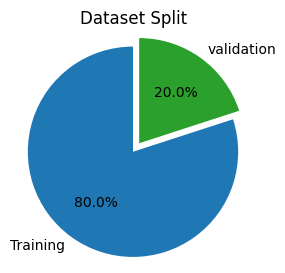

In [126]:
%matplotlib inline
label= ['Training','validation']
colors=['tab:blue', 'tab:green']
myexplode = [0.1, 0]
fig1, ax1 = plt.subplots(figsize=(3, 3))
data= [int(len(x_train)),int(len(x_val))]
plt.pie(data, labels=label, autopct='%1.1f%%', startangle=90, colors=colors,explode = myexplode)
plt.title('Dataset Split')
ax1.axis('equal')
plt.show()

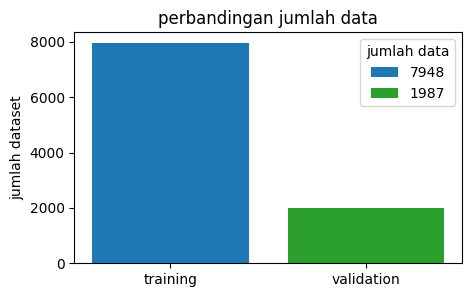

In [127]:
%matplotlib inline
fig2,ax2 = plt.subplots(figsize=(5, 3))

datasplit = ['training', 'validation']
counts_dataset =  [len(x_train),len(x_val)]
bar_labels = [len(x_train),len(x_val)]
bar_colors = ['tab:blue','tab:green']

ax2.bar(datasplit, counts_dataset,label=bar_labels, color=bar_colors)
ax2.set_ylabel('jumlah dataset')
ax2.set_title('perbandingan jumlah data')
ax2.legend(title='jumlah data')
plt.show()

In [128]:
df_rating_filtered_copy['rating'].value_counts().sort_index()

0.0     2204
1.0       92
2.0       93
3.0      108
4.0      149
5.0      367
6.0      678
7.0     1462
8.0     1899
9.0     1684
10.0    1199
Name: rating, dtype: int64

<Axes: xlabel='rating'>

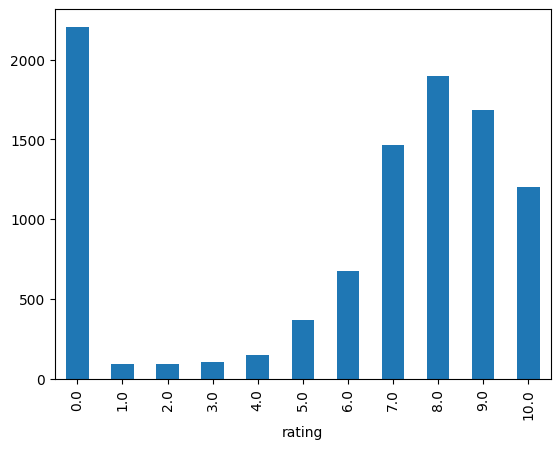

In [129]:
df_rating_filtered_copy.groupby('rating').size().plot(kind='bar')

### Proses Training

model menghitung skor kecocokan antara pengguna dan data anime dengan teknik embedding
* Pertama, kita melakukan proses embedding terhadap data user dan data anime.
* Selanjutnya, lakukan operasi perkalian dot product antara embedding user dan data anime.
* kita juga dapat menambahkan bias untuk setiap user dan data anime.
* Skor kecocokan ditetapkan dalam skala [0,1] dengan fungsi aktivasi sigmoid.

In [130]:
class RecommenderNet(tf.keras.Model):
  def __init__(self, num_users, num_anime, embedding_size, **kwargs):
    super(RecommenderNet, self).__init__(**kwargs)
    self.num_users = num_users
    self.num_anime = num_anime
    self.embedding_size = embedding_size
    self.user_embedding = layers.Embedding(
        num_users,
        embedding_size,
        embeddings_initializer = 'he_normal',
        embeddings_regularizer = keras.regularizers.l2(1e-6)
    )
    self.user_bias = layers.Embedding(num_users, 1)
    self.anime_embedding = layers.Embedding(
        num_anime,
        embedding_size,
        embeddings_initializer = 'he_normal',
        embeddings_regularizer = keras.regularizers.l2(1e-6)
    )
    self.anime_bias = layers.Embedding(num_anime, 1)

  def call(self,inputs):
    user_vector = self.user_embedding(inputs[:,0])
    user_bias = self.user_bias(inputs[:, 0])
    anime_vector = self.anime_embedding(inputs[:, 1])
    anime_bias = self.anime_bias(inputs[:, 1])

    dot_user_anime = tf.tensordot(user_vector, anime_vector, 2)
    x = dot_user_anime + user_bias + anime_bias

    return tf.nn.sigmoid(x)

> selanjutnya proses compile moded

In [131]:
model = RecommenderNet(num_users, num_anime, 50)
model.compile(
  loss = tf.keras.losses.BinaryCrossentropy(),
  optimizer = keras.optimizers.Adam(learning_rate=0.002),
  metrics=[tf.keras.metrics.RootMeanSquaredError()],
)

> Mulai Proses Training

In [132]:
history = model.fit(
    x = x_train,
    y = y_train,
    epochs = 100,
    validation_data = (x_val, y_val)
)

Epoch 1/100
249/249 [==============================] - 2s 4ms/step - loss: 0.6576 - root_mean_squared_error: 0.3604 - val_loss: 0.6857 - val_root_mean_squared_error: 0.3212
Epoch 2/100
249/249 [==============================] - 1s 3ms/step - loss: 0.6207 - root_mean_squared_error: 0.3353 - val_loss: 0.6872 - val_root_mean_squared_error: 0.3223
Epoch 3/100
249/249 [==============================] - 1s 3ms/step - loss: 0.5792 - root_mean_squared_error: 0.3058 - val_loss: 0.6782 - val_root_mean_squared_error: 0.3153
Epoch 4/100
249/249 [==============================] - 1s 3ms/step - loss: 0.5272 - root_mean_squared_error: 0.2634 - val_loss: 0.6775 - val_root_mean_squared_error: 0.3148
Epoch 5/100
249/249 [==============================] - 1s 5ms/step - loss: 0.5014 - root_mean_squared_error: 0.2423 - val_loss: 0.6734 - val_root_mean_squared_error: 0.3116
Epoch 6/100
249/249 [==============================] - 1s 4ms/step - loss: 0.4818 - root_mean_squared_error: 0.2253 - val_loss: 0.6726 

In [133]:
evaluation = model.evaluate(x_val, y_val)


63/63 [==============================] - 0s 1ms/step - loss: 0.6921 - root_mean_squared_error: 0.3177


In [134]:
print("val_Loss :", evaluation[0])
print("Root Mean Squared Error :", evaluation[1])

val_Loss : 0.6920642852783203
Root Mean Squared Error : 0.3176895081996918


### Visualisasi Metrik

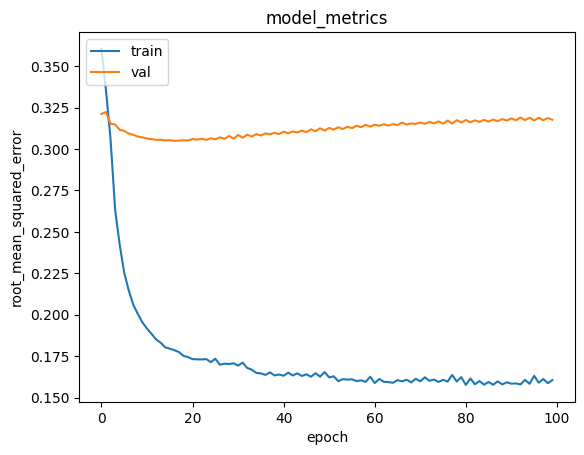

In [135]:
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title('model_metrics')
plt.ylabel('root_mean_squared_error')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc= 'upper left')
plt.show()

> mengambil sample user

In [146]:
anime_df = anime_new
df = df_rating_filtered
user_id = df.user_id.sample(1).iloc[0]
anime_visited_by_user = df[df.user_id == user_id]

anime_not_visited = anime_df[~anime_df['id'].isin(anime_visited_by_user.user_id.values)]['id']
anime_not_visited = list(
    set(anime_not_visited)
    .intersection(set(anime_to_anime_encoded.keys()))
)

anime_not_visited = [[anime_to_anime_encoded.get(x)] for x in anime_not_visited]
user_encoder = user_to_user_encoded.get(user_id)
user_anime_array = np.hstack(
    ([[user_encoder]] * len(anime_not_visited), anime_not_visited)
)

> Percobaan Model Prediksi

In [147]:
ratings = model.predict(user_anime_array).flatten()

top_ratings_indices = ratings.argsort()[-10:][::-1]
recommended_anime_ids = [
    anime_encoded_to_anime.get(anime_not_visited[x][0]) for x in top_ratings_indices
]

print('Showing recommendations for users: {}'.format(user_id))
print('===' * 9)
print('Anime with high ratings from user')
print('----' * 8)

top_anime_user = (
    anime_visited_by_user.sort_values(
        by = 'rating',
        ascending = False
    )
    .head(5)
    .anime_id.values
)

anime_df_rows = anime_df[anime_df['id'].isin(top_anime_user)]
for row in anime_df_rows.itertuples():
    print(row.anime_name, ':', row.anime_genre)

print('----' * 8)
print('Top 10 Anime recommendation')
print('----' * 8)

recommended_anime = anime_df[anime_df['id'].isin(recommended_anime_ids)]
for row in recommended_anime.itertuples():
    print(row.anime_name, ':', row.anime_genre)

74/74 [==============================] - 0s 975us/step
Showing recommendations for users: U43
Anime with high ratings from user
--------------------------------
Tengen Toppa Gurren Lagann : Action, Adventure, Comedy, Mecha, Sci-Fi
Darker than Black: Kuro no Keiyakusha : Action, Mystery, Sci-Fi, Super Power
Steins;Gate : Sci-Fi, Thriller
Cowboy Bebop : Action, Adventure, Comedy, Drama, Sci-Fi, Space
Durarara!!x2 Ketsu : Action, Mystery, Supernatural
--------------------------------
Top 10 Anime recommendation
--------------------------------
Neon Genesis Evangelion: The End of Evangelion : Dementia, Drama, Mecha, Psychological, Sci-Fi
Interstella5555: The 5tory of The 5ecret 5tar 5ystem : Adventure, Drama, Music, Sci-Fi
Tokyo Majin Gakuen Kenpucho: Tou : Action, Drama, Fantasy, Horror, Martial Arts, School, Supernatural
Je T&#039;aime : Sci-Fi
K-On!: Live House! : Comedy, Music, School, Slice of Life
Natsume Yuujinchou Shi : Drama, Fantasy, Shoujo, Slice of Life, Supernatural
Senyuu. Sp